<center>
<img src="FIFA-19-Background-1-768x401.jpg" />
    
## Aprendizaje No Supervisado 2020 DiploDatos
    Laura Alonso Alemany, Ana Georgina Flesia y Valeria Rulloni
## Agrupamiento con el FIFA 2020 dataset
    
Material basado en notas de Ana Georgina Flesia bajo los términos y condiciones de la licencia [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/), a su vez basado de material de [SilveMel](https://www.kaggle.com/karangadiya/fifa19/downloads/data.csv/comments) y otros.

### Indice de temas
1. [Inicialización del entorno](#1.-Inicialización-del-entorno)
2. [Preparación de los datos](#2.-Preparación-de-los-datos)
3. [Clustering KM](#3.-Clustering-con-Kmeans)
4. [Clustering MS](#4.-Clustering-con-Mean-Shift)
5. [Clustering KM2](#5.-Clustering-con-Kmeans-sin-arqueros)
6. [Clustering MS2](#6.-Clustering-con-Mean-Shift-sin-arqueros)

## 1.-Inicialización-del-entorno

Empezamos cargando algunas herramientas para cargar los datos y manipularlos.

In [122]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

Para visualización usamos plotly, pero podemos usar seaborn tambien, o matplotlib. 

In [123]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

In [124]:
def save_skills_graph(skills_ratings, clusters, bool_crack, folder_path='imagenes/temporal/' ):
    for i in range(len(skills_ratings)):
        for j in range(i + 1, len(skills_ratings)):
            #Eligo dos números entre 0 y  de n_skills-1
            skill_1 = skills_ratings[i]
            skill_2 = skills_ratings[j]

            kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                                        mode='markers',
                                        text=df_n.loc[:,'team_position'], # 'height', 'weight', 'club', 'age', 'short_name', 'position'
                                        marker=dict(
                                            size=5,
                                            color = clusters.astype(np.float), #set color equal to a variable
                                            colorscale='Portland',
                                            showscale=False)
                                       )

            crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Ckacks!!',
                                  text=df_n.loc[bool_crack,'short_name'],
                                  textfont=dict(family='sans serif',size=10,color='black'),
                                  opacity=0.9,mode='text')

            data=[kmean_clusters,crack]

            layout = go.Layout(title="Clustering K means - K = {} ".format(n_clust),titlefont=dict(size=20),
                            xaxis=dict(title=skill_1),
                            yaxis=dict(title=skill_2),
                            autosize=False, width=1000,height=1000)

            fig = go.Figure(data=data, layout=layout)

            file_path = folder_path + '{}_vs_{}.png'.format(skill_1, skill_2)
            #iplot(fig)
            fig.write_image(file_path)

## 2.-Preparación-de-los-datos

Cargamos los datos bajados de la database de [Kaggle](https://www.kaggle.com/karangadiya/fifa19) como 'data.csv'. 

In [125]:
df=pd.read_csv("players_20.csv")
df.describe()
null_columns = df.columns[df.isnull().any()]
null_columns.to_list()

df_2019= pd.read_csv("data.csv")
df_2019[df_2019.isna().any(axis=1)]

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [126]:
df.isna().sum()

sofifa_id                         0
player_url                        0
short_name                        0
long_name                         0
age                               0
dob                               0
height_cm                         0
weight_kg                         0
nationality                       0
club                              0
overall                           0
potential                         0
value_eur                         0
wage_eur                          0
player_positions                  0
preferred_foot                    0
international_reputation          0
weak_foot                         0
skill_moves                       0
work_rate                         0
body_type                         0
real_face                         0
release_clause_eur             1298
player_tags                   16779
team_position                   240
team_jersey_number              240
loaned_from                   17230
joined                      

**Preparamos la base para Clustering:**

**Retiramos jugadores con bajo Desempeño global ("Overall")**

**y consideramos Variables de desempeño por habilidad (skills_ratings)**

In [127]:
n = 1000  # cantidad de jugadores a considerar

df_n = df.loc[:n]  # se reduce la base a los n primeros jugadores

df_n = df_n[(df_n.overall > 70)]

skills_ratings = ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
                  'passing', 'attacking_short_passing', 'attacking_volleys', 'dribbling',
                  'skill_dribbling', 'skill_curve', 'skill_fk_accuracy',
                  'skill_ball_control', 'movement_acceleration',
                  'movement_sprint_speed', 'movement_agility', 'movement_reactions',
                  'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina',
                  'power_strength', 'power_long_shots', 'mentality_aggression',
                  'mentality_interceptions', 'mentality_positioning', 'mentality_vision',
                  'mentality_penalties',  'mentality_composure', 'defending_marking',
                  'defending_standing_tackle', 'defending_sliding_tackle',
                  'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes',
                  'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
                  'goalkeeping_positioning', 'goalkeeping_reflexes',]
print(len(skills_ratings), 'variables numéricas de desempeño según habilidad')

df_skills=df_n[skills_ratings]
df_skills.isna().sum()


40 variables numéricas de desempeño según habilidad


attacking_crossing              0
attacking_finishing             0
attacking_heading_accuracy      0
passing                       109
attacking_short_passing         0
attacking_volleys               0
dribbling                     109
skill_dribbling                 0
skill_curve                     0
skill_fk_accuracy               0
skill_ball_control              0
movement_acceleration           0
movement_sprint_speed           0
movement_agility                0
movement_reactions              0
movement_balance                0
power_shot_power                0
power_jumping                   0
power_stamina                   0
power_strength                  0
power_long_shots                0
mentality_aggression            0
mentality_interceptions         0
mentality_positioning           0
mentality_vision                0
mentality_penalties             0
mentality_composure             0
defending_marking               0
defending_standing_tackle       0
defending_slid

### Se decidio sacar del analisis los skills gk_diving, gk_handling, gk_kicking, gk_positioning, gk_reflexes debido a que el 80% es null

In [128]:
skills_ratings = ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
                  'passing', 'attacking_short_passing', 'attacking_volleys', 'dribbling',
                  'skill_dribbling', 'skill_curve', 'skill_fk_accuracy',
                  'skill_ball_control', 'movement_acceleration',
                  'movement_sprint_speed', 'movement_agility', 'movement_reactions',
                  'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina',
                  'power_strength', 'power_long_shots', 'mentality_aggression',
                  'mentality_interceptions', 'mentality_positioning', 'mentality_vision',
                  'mentality_penalties',  'mentality_composure', 'defending_marking',
                  'defending_standing_tackle', 'defending_sliding_tackle',
                  'goalkeeping_diving', 
                  'goalkeeping_handling', 'goalkeeping_kicking',
                  'goalkeeping_positioning', 'goalkeeping_reflexes',]
print(len(skills_ratings), 'variables numéricas de desempeño según habilidad')

# Para no perder informacion se reemplazán los valores nulos por el promedio.
df_n = df_n.fillna(df_n.mean())

df_skills =df_n[skills_ratings]
df_skills.isna().sum()

35 variables numéricas de desempeño según habilidad


attacking_crossing            0
attacking_finishing           0
attacking_heading_accuracy    0
passing                       0
attacking_short_passing       0
attacking_volleys             0
dribbling                     0
skill_dribbling               0
skill_curve                   0
skill_fk_accuracy             0
skill_ball_control            0
movement_acceleration         0
movement_sprint_speed         0
movement_agility              0
movement_reactions            0
movement_balance              0
power_shot_power              0
power_jumping                 0
power_stamina                 0
power_strength                0
power_long_shots              0
mentality_aggression          0
mentality_interceptions       0
mentality_positioning         0
mentality_vision              0
mentality_penalties           0
mentality_composure           0
defending_marking             0
defending_standing_tackle     0
defending_sliding_tackle      0
goalkeeping_diving            0
goalkeep

# 3.-Clustering-con-Kmeans

ES necesario definirle la cantidad de grupos/clusters (n_clusters), es un hiperparámetro del algoritmo. 


In [129]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition

# Número de clusters buscado
n_clust = 4

km = KMeans(n_clusters=n_clust)
km.fit(df_skills)

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster / Inertia: ', km.inertia_)

Suma de los cuadrados de las distancias al cluster / Inertia:  2469642.153705632


**Elección de la cantidad de grupos/clusters**

Una forma de seleccionar la cantidad más adecuada de clusters es probar varias cantidades y usar el criterio del codo: "elbow method", utilizando una medida de ajuste que puede ser Inertia.

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

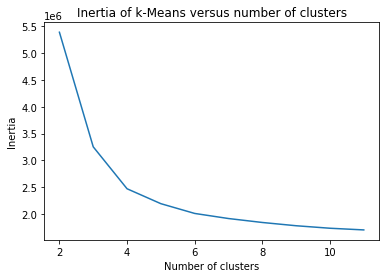

In [130]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i+2).fit(df_skills).inertia_ for i in range(10)]

from matplotlib import pyplot as plt
plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

**Graficamos el resultado kmedias con la cantidad de clases elegida: Visualizamos de a dos variables por vez**

In [131]:
data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[skills_ratings.index('skill_dribbling')]
skill_2=skills_ratings[skills_ratings.index('skill_ball_control')]

'''
'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
                  'passing', 'attacking_short_passing', 'attacking_volleys', 'dribbling',
                  'skill_dribbling', 'skill_curve', 'skill_fk_accuracy',
                  'skill_ball_control', 'movement_acceleration',
                  'movement_sprint_speed', 'movement_agility', 'movement_reactions',
                  'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina',
                  'power_strength', 'power_long_shots', 'mentality_aggression',
                  'mentality_interceptions', 'mentality_positioning', 'mentality_vision',
                  'mentality_penalties',  'mentality_composure', 'defending_marking',
                  'defending_standing_tackle', 'defending_sliding_tackle',
                  'goalkeeping_diving', 
                  'goalkeeping_handling', 'goalkeeping_kicking',
                  'goalkeeping_positioning', 'goalkeeping_reflexes',]
print(len(skills_ratings), 'variables numéricas de desempeño según habilidad'
'''

kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                            mode='markers',
                            text=df_n.loc[:,'team_position'],
                            marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Ckacks!!',
                      text=df_n.loc[bool_crack,'team_position'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means - K = {} ".format(n_clust),titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [132]:
df_clusters=df_n.copy()
df_clusters['kmeans'] = km.labels_ #clusters
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')

Kmeans encontró:  4 clusters, nosotros forzamos la cantidad


In [133]:
save_skills_graph(skills_ratings, clusters, bool_crack, folder_path='imagenes/imagenes_2020_k_means/' )

**EVALUACIÓN**

**EJERCICIO: Análisis exploratorio de los clusters, usando las clases asignadas por kmeans** 
- Cantidad de observaciones por Cluster
- Análisis descriptivo separando por Cluster
- Tabla de contingencia alguna categórica vs clusters
- Silohuette?


In [110]:
len(km.labels_)

1001

# 4.-Clustering-Mean-Shift 

- NO es necesario definirle la cantidad de grupos/clusters
- NO es escalable, computacionalmente es muy pesado. Cada dato tienen un proceso iterativo en donde en cada iteración considera los vecinos a menos de un radio de distancia.
- Hipeparámetros: radio (de cobertura para cálculo de media)

In [21]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition

ms = MeanShift(bandwidth=2, bin_seeding=True)

ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Numero estimado de clusters para Mean Shift : %d" % n_clusters_)

# Etquetas de los elementos de los clusters


Numero estimado de clusters para Mean Shift : 10


In [26]:
data=[]
bool_crack=df_n["Overall"] > 85
bool_no_crack=df_n["Overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[5]
skill_2=skills_ratings[14]


MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'Name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'Name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [22]:
df_clusters['MeanShift'] = ms.labels_ #clusters2
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros lo forzamos')
print('Mean shift encontró ', max(ms.labels_)+1, 'clusters, según los hiperparámetros elegidos')

Kmeans encontró:  5 clusters, nosotros lo forzamos
Mean shift encontró  10 clusters, según los hiperparámetros elegidos


**EVALUACIÓN**

**EJERCICIO EN GRUPO: Análisis exploratorio de los clusters, usando las clases asignadas por MeanShift** 

In [ ]:
#Cantidad de observaciones por Cluster
#Análisis descriptivo separando por Cluster
#Tabla de contingencia alguna categórica vs clusters
#Silohuette?


**Pregunta: normalizamos/estandarizamos la base?**

**Ahora vemos que agrupamientos podemos hacer excluyendo los arqueros**

# 5.-Clustering-con-Kmeans-sin-arqueros

In [31]:
n=10000

df_n=df.loc[:n]
df_n=df_n[(df_n["Position"]!='GK')&(df_n['Overall']>69)]

skills_ratings = ['Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle']

df_skills=df_n[skills_ratings]


In [32]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition

# Número de clusters buscado
n_clust = 5

km = KMeans(n_clusters=n_clust)
km.fit(df_skills)

# Recuperacion de etiquetas
clusters = km.labels_


In [33]:
data=[]
bool_crack=df_n["Overall"] > 85
bool_no_crack=df_n["Overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[5]
skill_2=skills_ratings[15]


kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'Name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'Name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

# 6.-Clustering-Mean-Shift-sin-arqueros 

In [34]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition


ms = MeanShift(bandwidth=2, bin_seeding=True)

ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Numero de clusters encontrado por Mean Shift : %d" % n_clusters_)


Numero de clusters encontrado por Mean Shift : 13


In [35]:
data=[]
bool_crack=df_n["Overall"] > 85
bool_no_crack=df_n["Overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[9]
skill_2=skills_ratings[10]


MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'Name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'Name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [36]:
df_clusters=df_skills
df_clusters['kmeans'] = km.labels_ #clusters
df_clusters['MeanShift'] = ms.labels_ #clusters2

**Análisis exploratorio de las clases**